# 学習済みLighGBM モデルの利用 (Teradata Bring-Your-Own-Model)

- このノートブックでは、Bring-Your-Own-Model (BYOM) の機能を用いて、LightGBMで作成した機械学習モデルをTeradataへインポートして推論に利用します
- データには、カリフォルニア州の住宅価格データを利用します

## ステップ
1. ローカル環境でLightGBMモデルを学習
2. [nyoka](https://github.com/SoftwareAG/nyoka) ライブラリによってPMML形式でエクスポート
3. PMMLファイルをTeradataへインストール
4. PMMLモデルをTeradata上のデータに適用し、予測値を計算

In [ ]:
%pip install pandas "sqlalchemy<2" ipython-sql teradataml scikit-learn matplotlib nyoka lightgbm "dask>2023.3.2" "distributed>2023.3.2"
# lightgbm との互換性のため、pandas ver.1 を利用
# teradatasqlalchemy との互換性のため、 sqlalchemy ver.1 を利用

import warnings
warnings.simplefilter("ignore", (FutureWarning, DeprecationWarning))
# pandas, teradataml の警告を非表示にして見やすくするため設定
# 実行結果には影響しない

In [ ]:
# 接続情報
from getpass import getpass
from urllib.parse import quote_plus

host = "host.docker.internal"
user = "demo_user"
database = "demo_user"
password = getpass("Password > ")
dbs_port = 1025
encryptdata = "true"

connstr = (
  f"teradatasql://{user}:{quote_plus(password)}@{host}/?"
  f"&database={database}"
  f"&dbs_port={dbs_port}"
  f"&encryptdata={encryptdata}"
)

%load_ext sql
%config SqlMagic.autopandas=True
%sql {connstr}

# 接続確認
%sql SELECT database, current_timestamp

In [ ]:
# teradataml のコンテキストを開始
from sqlalchemy import create_engine
from teradataml import create_context, remove_context
engine = create_engine(connstr)
context = create_context(tdsqlengine=engine, temp_database_name=user)

# 接続確認
import teradataml
teradataml.DataFrame('"dbc"."dbcInfoV"')

## データの準備

例として、scikit-learnライブラリで提供されている住宅価格予測データを用いる。

In [ ]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
df = data["data"]
df.insert(0, "target", data["target"])
display(df)


# teradata へデータをロード
from teradataml import copy_to_sql
copy_to_sql(df, "housing", if_exists="replace", index=True)

# test
teradataml.DataFrame("housing")

### 学習・テストデータに分割

index_labelは意味を持たない整数値なので、このの剰余を用いて分割することで再現性を担保する。

In [ ]:
df = teradataml.DataFrame("housing")
df_tr = df[df.index_label.mod(5) > 0]
df_te = df[df.index_label.mod(5) == 0]

copy_to_sql(df_tr, "housing_tr", if_exists="replace")
copy_to_sql(df_te, "housing_te", if_exists="replace")

# 確認
x_tr = teradataml.DataFrame("housing_tr")
x_te = teradataml.DataFrame("housing_te")
print(x_tr.shape)
print(x_te.shape)
display(x_tr)
display(x_te)

## LightGBMモデルの学習

外部環境（Jupyter上）でモデル学習を行います。

In [ ]:
from lightgbm import LGBMRegressor

model = Pipeline([
  ("scale", MinMaxScaler()),
  ("lgbm", LGBMRegressor(n_estimators=120, max_depth=7))
])

# データをローカルへ抽出
tmp = df_tr.to_pandas()
X_tr = tmp.drop(columns=["index_label", "target"])
X_tr.index = tmp.index_label
Y_tr = tmp.target
model.fit(X_tr, Y_tr)

In [ ]:
# 学習データ、テストデータでのパフォーマンスを確認
# チューニングは割愛
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate_model(model, x, y):
  pred = model.predict(x)
  mae = mean_absolute_error(y, pred)
  mse = mean_squared_error(y, pred)
  r2 = r2_score(y, pred)
  print(f"Mean absolute error: {mae}")
  print(f"Mean squared error : {mse}")
  print(f"R2                 : {r2}")

print("Training score *****")
evaluate_model(model, X_tr, Y_tr)
print("******")

# テストデータをローカルへ抽出
tmp = x_te.to_pandas()
X_te = tmp.drop(columns=["index_label", "target"])
X_te.index = tmp.index_label
Y_te = tmp.target
print("Test score *****")
evaluate_model(model, X_te, Y_te)
print("******")

In [53]:
print("Training score *****")
evaluate_model(model, X_tr, Y_tr)
print("******")

# テストデータをローカルへ抽出
tmp = df_te.to_pandas()
X_te = tmp.drop(columns=["index_label", "target"])
X_te.index = tmp.index_label
Y_te = tmp.target
print("Test score *****")
evaluate_model(model, X_te, Y_te)
print("******")

Training score *****
Mean absolute error: 0.2676825771509856
Mean squared error : 0.15337203578550618
R2                 : 0.8846605938735113
******
Test score *****
Mean absolute error: 0.3018022034796184
Mean squared error : 0.2063706584084526
R2                 : 0.8458469125219761
******


## LightGBMモデルをTeradataへインポート

### LightGBMモデルをPMMLに書き出し

In [54]:
from nyoka import lgb_to_pmml
feature_names = X_tr.columns
target_name = "target"
filename2 = "housing_lgbm.pmml"
lgb_to_pmml(model, feature_names, target_name, filename2)

In [55]:
# 内容を確認
!head -n15 {filename}

<?xml version="1.0" encoding="UTF-8"?>
<PMML xmlns="http://www.dmg.org/PMML-4_4" version="4.4.1">
    <Header copyright="Copyright (c) 2021 Software AG" description="Default description">
        <Application name="Nyoka" version="5.4.0"/>
        <Timestamp>2023-06-14 05:48:21.216716</Timestamp>
    </Header>
    <DataDictionary numberOfFields="9">
        <DataField name="MedInc" optype="continuous" dataType="double"/>
        <DataField name="HouseAge" optype="continuous" dataType="double"/>
        <DataField name="AveRooms" optype="continuous" dataType="double"/>
        <DataField name="AveBedrms" optype="continuous" dataType="double"/>
        <DataField name="Population" optype="continuous" dataType="double"/>
        <DataField name="AveOccup" optype="continuous" dataType="double"/>
        <DataField name="Latitude" optype="continuous" dataType="double"/>
        <DataField name="Longitude" optype="continuous" dataType="double"/>


### PMMLをTeradataへインポート

In [56]:
from teradataml import save_byom, delete_byom

# すでに同IDのモデルがある場合は前もって削除
try:
  delete_byom(model_id="housing_lgbm", table_name="housing_models")
except Exception as e:
  print(f"{e}", file=sys.stderr)
    
save_byom(model_id="housing_lgbm", model_file=filename2, table_name="housing_models")

Model is deleted.
Model is saved.


In [ ]:
# モデル確認
%sql SELECT * FROM housing_models

## LightGBMモデルを用いてTeradata上で予測

In [58]:
from teradataml import PMMLPredict, retrieve_byom

teradataml.configure.byom_install_location = "mldb"
# Bring-Your-Own-Model 関数の場所を指定
# 実際の環境により変化することがある

# 予測に使うテーブルとモデルオブジェクト
newdata = teradataml.DataFrame("housing_te")  # 予測に用いるテーブル。このモデルは列名で必要な変数を判断するので余計な列があっても良い
modeldata = retrieve_byom(model_id="housing_lgbm", table_name="housing_models")  # 予測モデルに対応する行

# H2Oモデルによる予測の実行
out = PMMLPredict(
  newdata=newdata,
  modeldata=modeldata,
  accumulate=["index_label"]
)

out2.result

index_label,prediction,json_report
10,2.271809782879815,"{""predicted_target"":2.271809782879815}"
20,1.2736992738418602,"{""predicted_target"":1.2736992738418602}"
25,1.4610565185926983,"{""predicted_target"":1.4610565185926983}"
30,1.3763147873689154,"{""predicted_target"":1.3763147873689154}"
40,1.411789922497766,"{""predicted_target"":1.411789922497766}"
45,2.032985203747107,"{""predicted_target"":2.032985203747107}"
16385,1.2700620431940592,"{""predicted_target"":1.2700620431940592}"
16390,1.7334157384504694,"{""predicted_target"":1.7334157384504694}"
16395,1.1415913558411674,"{""predicted_target"":1.1415913558411674}"
16400,2.1266527442953165,"{""predicted_target"":2.1266527442953165}"


### ローカル環境での予測結果と比較

In [59]:
import pandas as pd
pred_local = model.predict(X_te)
pred_local = pd.DataFrame({"predict_local": pred_local})
pred_local.index = X_te.index
pred_local = pred_local.reset_index()
display(pred_local)

pred_td = out.result.to_pandas().rename(columns={"prediction":"predict_td"})
pred_td.predict_td = pred_td.predict_td.astype(float)
pred_td

,index_label,predict_local
0,16385,1.270062
1,0,4.161990
2,16390,1.733416
3,5,2.436446
4,16395,1.141591
...,...,...
4123,16360,0.780770
4124,16365,0.976115
4125,16370,1.146254
4126,16375,0.973707


,index_label,predict_td,json_report
0,16385,1.270062,"{""predicted_target"":1.2700620431940592}"
1,0,4.161990,"{""predicted_target"":4.161990475550776}"
2,16390,1.733416,"{""predicted_target"":1.7334157384504694}"
3,5,2.436446,"{""predicted_target"":2.4364460997027897}"
4,16395,1.141591,"{""predicted_target"":1.1415913558411674}"
...,...,...,...
4123,16360,0.780770,"{""predicted_target"":0.780769851818171}"
4124,16365,0.976115,"{""predicted_target"":0.976114555976915}"
4125,16370,1.146254,"{""predicted_target"":1.1462537679052782}"
4126,16375,0.973707,"{""predicted_target"":0.9737070942347364}"


In [60]:
import pandas as pd

pred_df = pd.merge(pred_local, pred_td)
pred_df

,index_label,predict_local,predict_td,json_report
0,16385,1.270062,1.270062,"{""predicted_target"":1.2700620431940592}"
1,0,4.161990,4.161990,"{""predicted_target"":4.161990475550776}"
2,16390,1.733416,1.733416,"{""predicted_target"":1.7334157384504694}"
3,5,2.436446,2.436446,"{""predicted_target"":2.4364460997027897}"
4,16395,1.141591,1.141591,"{""predicted_target"":1.1415913558411674}"
...,...,...,...,...
4123,16360,0.780770,0.780770,"{""predicted_target"":0.780769851818171}"
4124,16365,0.976115,0.976115,"{""predicted_target"":0.976114555976915}"
4125,16370,1.146254,1.146254,"{""predicted_target"":1.1462537679052782}"
4126,16375,0.973707,0.973707,"{""predicted_target"":0.9737070942347364}"


Max deviation: 0.0
Correlation: 0.9999999999999998


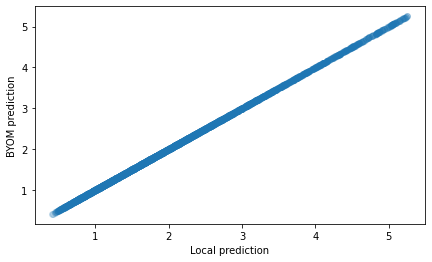

In [61]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(7, 4))
print(f"Max deviation: {(pred_df.predict_local - pred_df.predict_td).abs().max()}")
print(f"Correlation: {np.corrcoef(pred_df.predict_local, pred_df.predict_td)[0,1]}")
ax.scatter(pred_df.predict_local, pred_df.predict_td, alpha=.2)
ax.set_xlabel("Local prediction")
ax.set_ylabel("BYOM prediction")
None

,abs_diff
count,4128.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


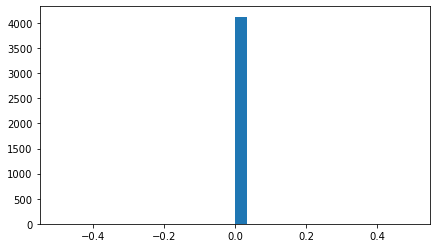

In [62]:
# 乖離の分布
deviation = (pred_df.predict_local - pred_df.predict_td)
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(deviation, bins=30)
pd.DataFrame({"abs_diff": np.abs(deviation)}).describe()